# Resampling, Smoothing, and the Illusion of Lower Risk

Resampling means converting a high-frequency series (daily prices) into lower-frequency observations (weekly/monthly/quarterly/annual), usually by taking the **last** price in each period.

Lower-frequency charts look smoother because many intra-period moves are hidden. This often makes risk appear lower.

In theory, annualised mean return should be roughly similar across sampling frequencies (with sampling error), while annualised volatility often falls as data are smoothed. That does **not** mean true economic risk disappeared; it means less short-horizon variation is being observed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.6f}'.format
plt.style.use('default')

## Load Data (MSFT with Robust Fallback)

In [2]:
def fetch_prices(symbol='MSFT', start='2010-01-01', end=None):
    """Fetch MSFT prices with fallback sequence:
    1) yfinance
    2) pandas_datareader (stooq)
    3) synthetic GBM series
    Returns: (price_series, source_label, notes_list)
    """
    if end is None:
        end = pd.Timestamp.today().normalize()
    else:
        end = pd.to_datetime(end).normalize()

    start_ts = pd.to_datetime(start)
    notes = []

    def _clean_price_series(series):
        series = pd.to_numeric(series, errors='coerce').dropna()
        series = series[~series.index.duplicated(keep='last')]
        series = series.sort_index()
        series.name = symbol
        return series

    # 1) yfinance attempt
    try:
        import yfinance as yf

        data = yf.download(
            symbol,
            start=start_ts.strftime('%Y-%m-%d'),
            end=end.strftime('%Y-%m-%d'),
            progress=False,
            auto_adjust=False,
            timeout=10
        )

        if not data.empty:
            if isinstance(data.columns, pd.MultiIndex):
                if 'Adj Close' in data.columns.get_level_values(0):
                    series = data['Adj Close'].iloc[:, 0]
                elif 'Close' in data.columns.get_level_values(0):
                    series = data['Close'].iloc[:, 0]
                else:
                    series = None
            else:
                if 'Adj Close' in data.columns:
                    series = data['Adj Close']
                elif 'Close' in data.columns:
                    series = data['Close']
                else:
                    series = None

            if series is not None:
                series = _clean_price_series(series)
                if not series.empty:
                    return series, 'yfinance', notes

        notes.append('yfinance returned empty data.')

    except Exception as exc:
        notes.append(f'yfinance failed: {exc}')

    # 2) pandas_datareader (stooq) attempt
    try:
        from pandas_datareader import data as web

        for ticker in [f'{symbol}.US', symbol]:
            try:
                stooq_data = web.DataReader(ticker, 'stooq', start_ts, end)
            except Exception as inner_exc:
                notes.append(f'stooq fetch failed for {ticker}: {inner_exc}')
                continue

            if stooq_data is None or stooq_data.empty:
                notes.append(f'stooq returned empty data for {ticker}.')
                continue

            stooq_data = stooq_data.sort_index()
            if 'Close' in stooq_data.columns:
                series = _clean_price_series(stooq_data['Close'])
                if not series.empty:
                    notes.append(f'Used stooq ticker: {ticker}')
                    return series, 'stooq', notes

    except Exception as exc:
        notes.append(f'pandas_datareader/stooq unavailable: {exc}')

    # 3) Synthetic fallback (GBM)
    business_days = pd.date_range(start=start_ts, end=end, freq='B')
    if len(business_days) < 2:
        raise ValueError('Not enough dates to build synthetic series.')

    rng = np.random.default_rng(42)
    mu_annual = 0.11
    sigma_annual = 0.28
    dt = 1 / 252

    shocks = rng.normal(
        loc=(mu_annual - 0.5 * sigma_annual ** 2) * dt,
        scale=sigma_annual * np.sqrt(dt),
        size=len(business_days)
    )

    log_price = np.log(100.0) + np.cumsum(shocks)
    synthetic_prices = pd.Series(np.exp(log_price), index=business_days, name=symbol)

    notes.append('Using synthetic GBM fallback: online price fetch unavailable.')
    return synthetic_prices, 'synthetic_gbm', notes


def resample_prices(prices, rule):
    if rule is None:
        return prices.dropna()
    # Keep requested labels (M/Q/Y) but map to modern pandas aliases.
    rule_map = {'M': 'ME', 'Q': 'QE', 'Y': 'YE', 'A': 'YE'}
    effective_rule = rule_map.get(rule, rule)
    return prices.resample(effective_rule).last().dropna()


def compute_annualised_metrics(prices, periods_per_year):
    log_returns = np.log(prices / prices.shift(1)).dropna()

    if log_returns.empty:
        return {
            'ann_mean_log': np.nan,
            'ann_mean_simple': np.nan,
            'ann_vol': np.nan
        }

    mean_return = log_returns.mean()
    std_return = log_returns.std(ddof=1)

    ann_mean_log = mean_return * periods_per_year
    ann_vol = std_return * np.sqrt(periods_per_year)
    ann_mean_simple = np.exp(ann_mean_log) - 1

    return {
        'ann_mean_log': ann_mean_log,
        'ann_mean_simple': ann_mean_simple,
        'ann_vol': ann_vol
    }

In [3]:
prices, data_source, fetch_notes = fetch_prices(symbol='MSFT', start='2010-01-01')

print(f'Data source: {data_source}')
if fetch_notes:
    print('Notes:')
    for note in fetch_notes:
        print(f'  - {note}')

print(f'Date range: {prices.index.min().date()} to {prices.index.max().date()}')
print(f'Observations: {len(prices)}')
prices.head()

Data source: yfinance
Date range: 2010-01-04 to 2026-02-25
Observations: 4061


Date
2010-01-04   23.077385
2010-01-05   23.084839
2010-01-06   22.943167
2010-01-07   22.704567
2010-01-08   22.861149
Name: MSFT, dtype: float64

## Daily and Monthly Price Views

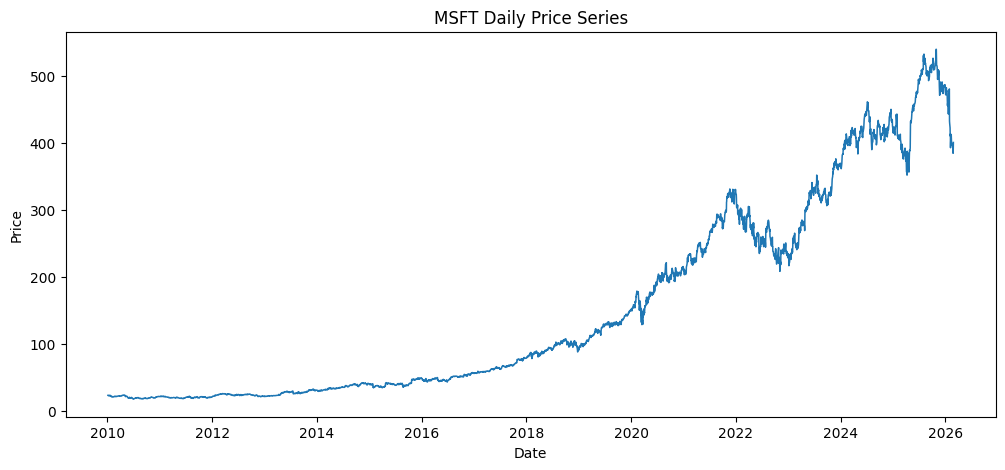

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(prices.index, prices.values, linewidth=1.1)
plt.title('MSFT Daily Price Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

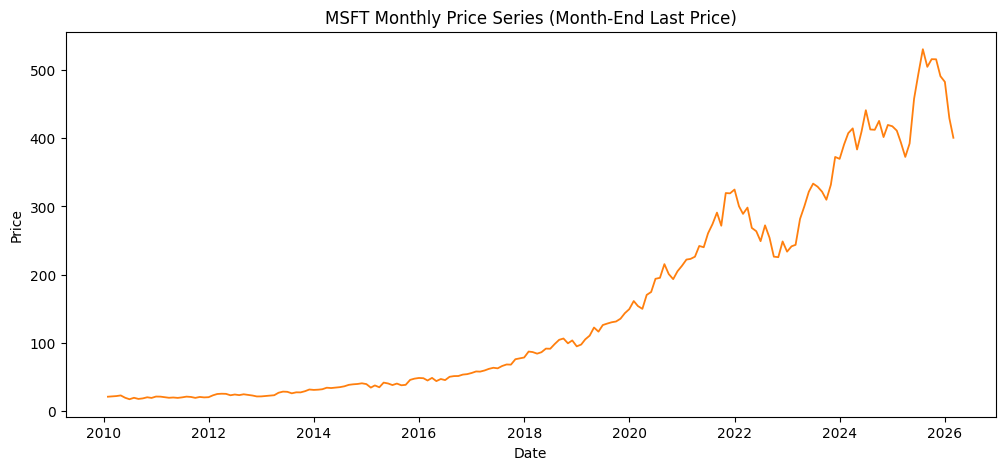

In [5]:
monthly_prices = resample_prices(prices, 'M')

plt.figure(figsize=(12, 5))
plt.plot(monthly_prices.index, monthly_prices.values, linewidth=1.3, color='tab:orange')
plt.title('MSFT Monthly Price Series (Month-End Last Price)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Frequency Comparison Table

In [6]:
frequency_settings = [
    ('Daily', None, 252),
    ('Weekly', 'W-FRI', 52),
    ('Monthly', 'M', 12),
    ('Quarterly', 'Q', 4),
    ('Annual', 'Y', 1),
]

rows = []
resampled_prices = {}
log_returns_by_frequency = {}

for frequency, rule, periods_per_year in frequency_settings:
    sampled_prices = resample_prices(prices, rule)
    resampled_prices[frequency] = sampled_prices

    sampled_log_returns = np.log(sampled_prices / sampled_prices.shift(1)).dropna()
    log_returns_by_frequency[frequency] = sampled_log_returns

    metrics = compute_annualised_metrics(sampled_prices, periods_per_year)
    rows.append({
        'frequency': frequency,
        'periods_per_year': periods_per_year,
        'ann_mean_log': metrics['ann_mean_log'],
        'ann_mean_simple': metrics['ann_mean_simple'],
        'ann_vol': metrics['ann_vol']
    })

results_df = pd.DataFrame(rows)
results_df = results_df[['frequency', 'periods_per_year', 'ann_mean_log', 'ann_mean_simple', 'ann_vol']]

print(results_df.to_string(index=False, float_format=lambda v: f'{v:.6f}'))
results_df

frequency  periods_per_year  ann_mean_log  ann_mean_simple  ann_vol
    Daily               252      0.177152         0.193812 0.256501
   Weekly                52      0.176845         0.193446 0.230976
  Monthly                12      0.183287         0.201159 0.213874
Quarterly                 4      0.181536         0.199057 0.223017
   Annual                 1      0.183555         0.201481 0.227018


,frequency,periods_per_year,ann_mean_log,ann_mean_simple,ann_vol
0,Daily,252,0.177152,0.193812,0.256501
1,Weekly,52,0.176845,0.193446,0.230976
2,Monthly,12,0.183287,0.201159,0.213874
3,Quarterly,4,0.181536,0.199057,0.223017
4,Annual,1,0.183555,0.201481,0.227018


Interpretation: annualised mean return is usually in the same broad range across frequencies, while annualised volatility often declines as sampling gets coarser (especially for monthly/quarterly/annual). This is the smoothing effect, not true elimination of underlying risk.

## Risk-Return Scatter by Sampling Frequency

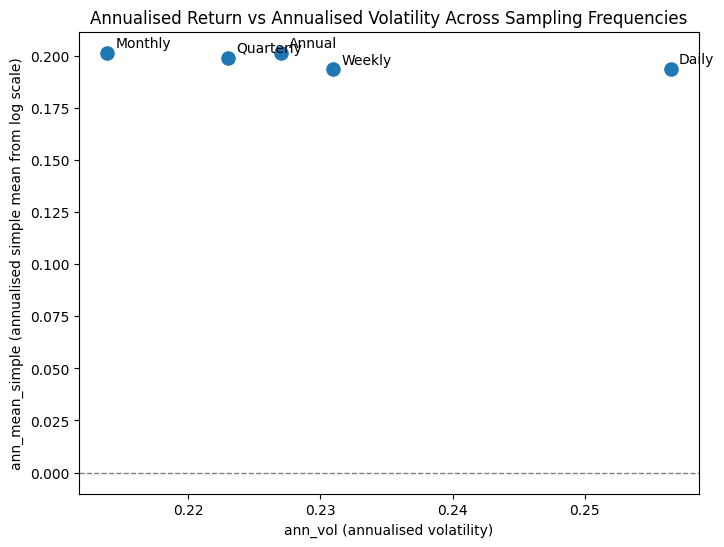

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(results_df['ann_vol'], results_df['ann_mean_simple'], s=90, color='tab:blue')

for _, row in results_df.iterrows():
    plt.annotate(
        row['frequency'],
        (row['ann_vol'], row['ann_mean_simple']),
        textcoords='offset points',
        xytext=(6, 4),
        fontsize=10
    )

plt.title('Annualised Return vs Annualised Volatility Across Sampling Frequencies')
plt.xlabel('ann_vol (annualised volatility)')
plt.ylabel('ann_mean_simple (annualised simple mean from log scale)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()

## Illusion Demonstration: One Month of Daily Moves vs One Monthly Return

Selected month: 2026-02
Number of daily log returns in month: 17
Single monthly log return: -0.069216
Daily return std within month: 0.021676


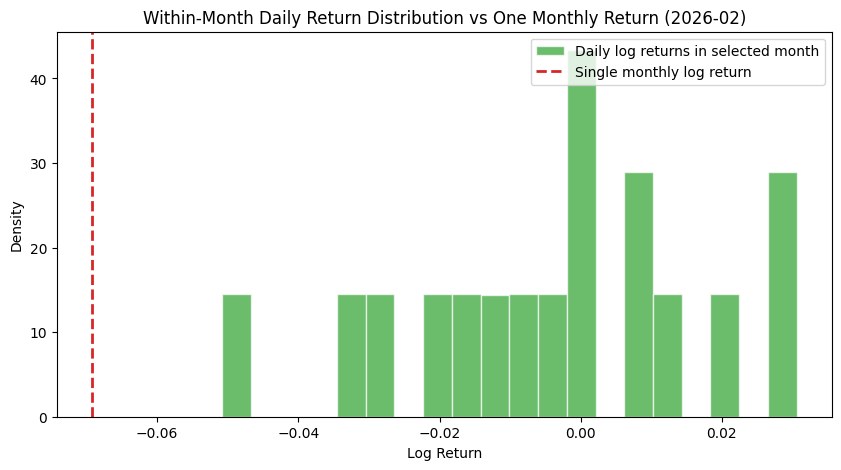

In [8]:
daily_prices = resample_prices(prices, None)
daily_log_returns = np.log(daily_prices / daily_prices.shift(1)).dropna()
monthly_log_returns = np.log(monthly_prices / monthly_prices.shift(1)).dropna()

selected_month_end = None
selected_daily_returns = None
selected_monthly_return = np.nan

for month_end in monthly_log_returns.index[::-1]:
    month_period = month_end.to_period('M')
    month_daily = daily_log_returns[daily_log_returns.index.to_period('M') == month_period]
    if len(month_daily) >= 10:
        selected_month_end = month_end
        selected_daily_returns = month_daily
        selected_monthly_return = monthly_log_returns.loc[month_end]
        break

if selected_month_end is None:
    selected_month_end = monthly_log_returns.index[-1]
    month_period = selected_month_end.to_period('M')
    selected_daily_returns = daily_log_returns[daily_log_returns.index.to_period('M') == month_period]
    selected_monthly_return = monthly_log_returns.loc[selected_month_end]

print(f"Selected month: {selected_month_end.to_period('M')}")
print(f'Number of daily log returns in month: {len(selected_daily_returns)}')
print(f'Single monthly log return: {selected_monthly_return:.6f}')
print(f'Daily return std within month: {selected_daily_returns.std(ddof=1):.6f}')

plt.figure(figsize=(10, 5))
plt.hist(selected_daily_returns, bins=20, density=True, alpha=0.70, color='tab:green', edgecolor='white', label='Daily log returns in selected month')
plt.axvline(selected_monthly_return, color='tab:red', linestyle='--', linewidth=2, label='Single monthly log return')
plt.title(f"Within-Month Daily Return Distribution vs One Monthly Return ({selected_month_end.to_period('M')})")
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.legend()
plt.show()

Takeaway: the monthly series keeps only one endpoint-to-endpoint move, while daily data show many ups and downs inside that month. Smoothing reduces observed volatility, but actual intra-period variability still exists.

## Best-Practice Notes

- Compare assets at the **same sampling frequency** to avoid distorted risk comparisons.
- Do not mix infrequently appraised assets (e.g., quarterly valuation-based real estate indices) with real-time traded prices without adjustment.
- Pick frequency based on strategy horizon, but do not assume risk is truly lower just because the series is sampled more coarsely.